In [13]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation, DataService  # type: ignore
import numpy as np
import pandas as pd
from scipy.ndimage import uniform_filter1d
import warnings
warnings.filterwarnings('ignore')

In [14]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [15]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [16]:
def factor(df):
    # 计算主动买入量占比
    df['buy_ratio'] = df['taker_buy_volume'] / (df['volume'] + 1e-7)
    
    # === 核心改进2: 流动性黑洞检测 ===
    # 1. 价格波动幅度
    df['price_range'] = (df['high'] - df['low']) / df['open']
    
    # 2. 成交量异常度
    volume_ma = df['volume'].ewm(span=96).mean()
    df['volume_anomaly'] = (df['volume'] - volume_ma) / volume_ma
    
    # 3. 买卖失衡度
    df['buy_sell_imbalance'] = (2 * df['taker_buy_volume'] - df['volume']) / df['volume']
    
    # 流动性黑洞指数 (LHI)
    df['lhi'] = (
        (df['price_range'] > df['price_range'].rolling(1440).quantile(0.9)) * 
        (df['volume_anomaly'] < -0.5) *  # 成交量骤降
        (df['buy_sell_imbalance'] < -0.3)  # 卖出主导
    ).astype(float).ewm(span=12).mean()  # 平滑处理
    
    # 计算价格波动率
    price_change = df['close'].pct_change()
    volatility = price_change.ewm(span=96, min_periods=24).std()
    
    # 计算量价比率 (黑洞效应调整)
    vp_ratio = df['volume'] / (volatility + 1e-7) * (1 - df['lhi'])
    
    # 关键周期定义
    periods = [96, 288, 672]
    
    # 计算各周期量价比率
    vp_matrix = np.column_stack([
        vp_ratio.ewm(span=p, min_periods=int(p/4)).mean()
        for p in periods
    ])
    
    # === 黑洞响应因子 ===
    # 1. 黑洞区域专用信号
    in_black_hole = (df['lhi'] > 0.5)
    
    # 2. 黑洞区域因子计算
    # - 使用短期价格变化
    short_term_change = df['close'].pct_change(8)
    # - 成交量变化方向
    volume_change = df['volume'].pct_change(8)
    # - 黑洞因子
    black_hole_factor = -np.sign(short_term_change) * np.sign(volume_change) * np.log1p(df['volume'])
    
    # 3. 正常区域因子
    normal_factor = np.mean(vp_matrix, axis=1) * df['buy_ratio']
    
    # 因子融合
    factor = np.where(in_black_hole, black_hole_factor, normal_factor)
    
    # 黑洞边缘平滑过渡
    lhi_weight = 1 / (1 + np.exp(-10*(df['lhi']-0.5)))  # Sigmoid转换
    factor = factor * (1 - lhi_weight) + black_hole_factor * lhi_weight
    
    return factor

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
📈 平稳性检验 (ADF):
   p_value: 0.000000
   是否平稳: 是
🔗 相关性分析:
   IC (Pearson): 0.018211
   Rank_IC (Spearman): 0.007749
📊 信息比率:
   IR: 0.389303
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 132012
   因子列: factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


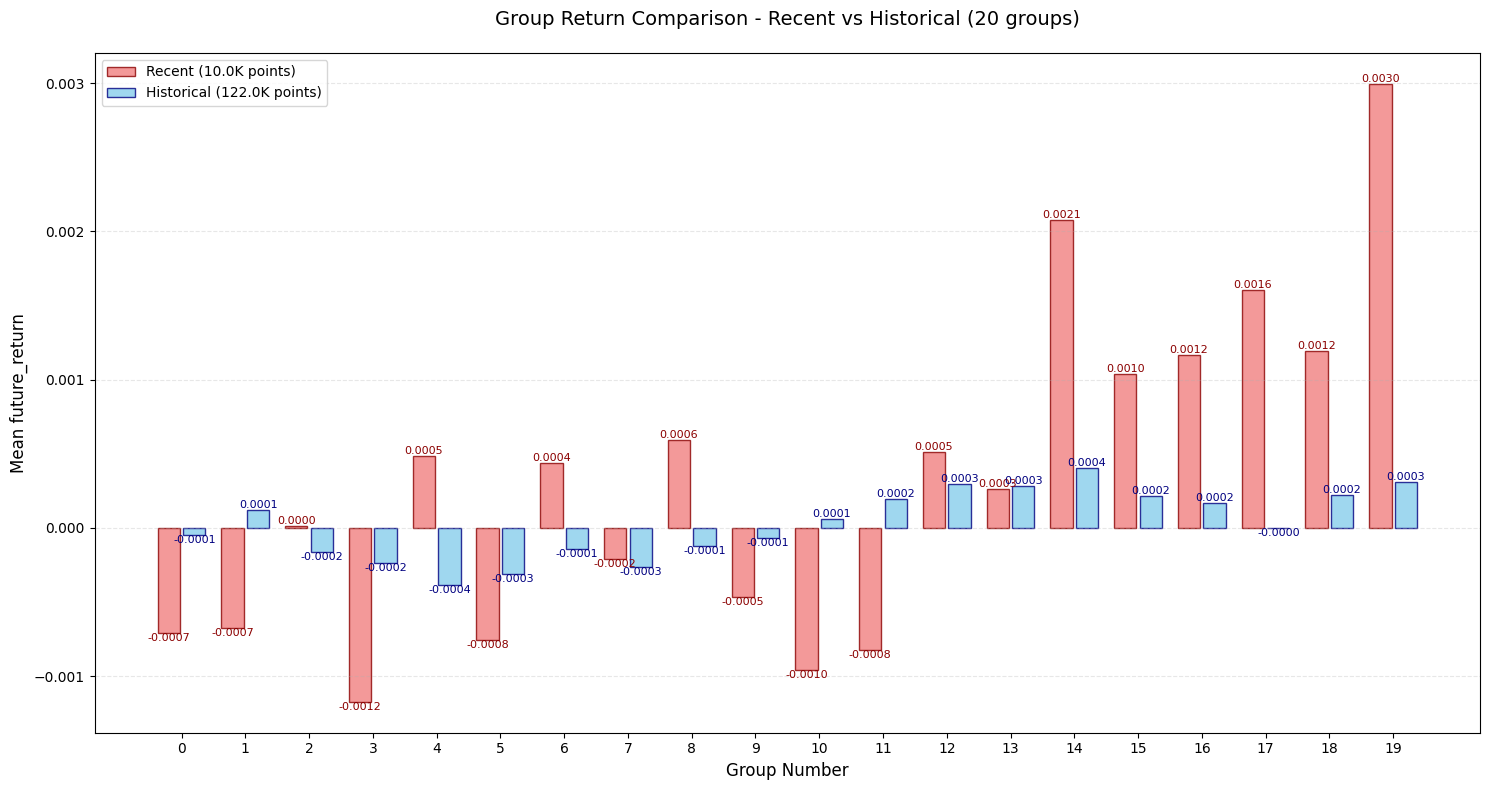

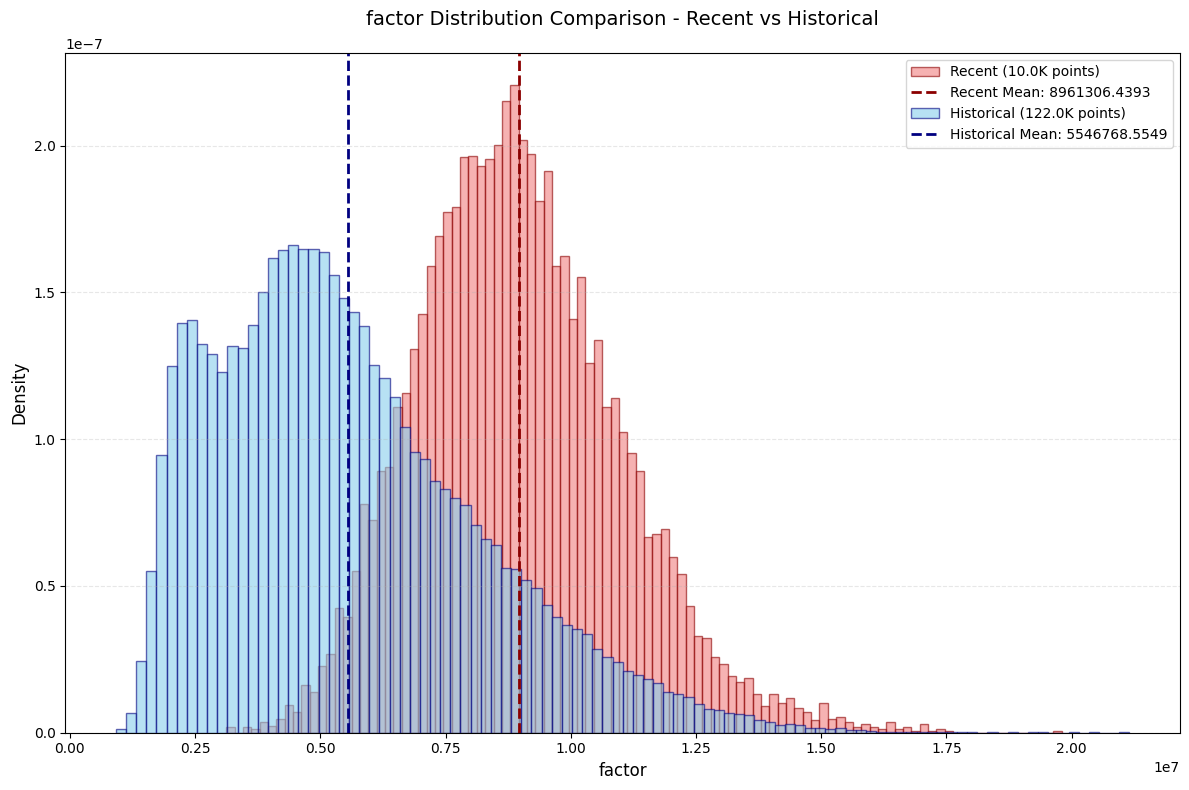

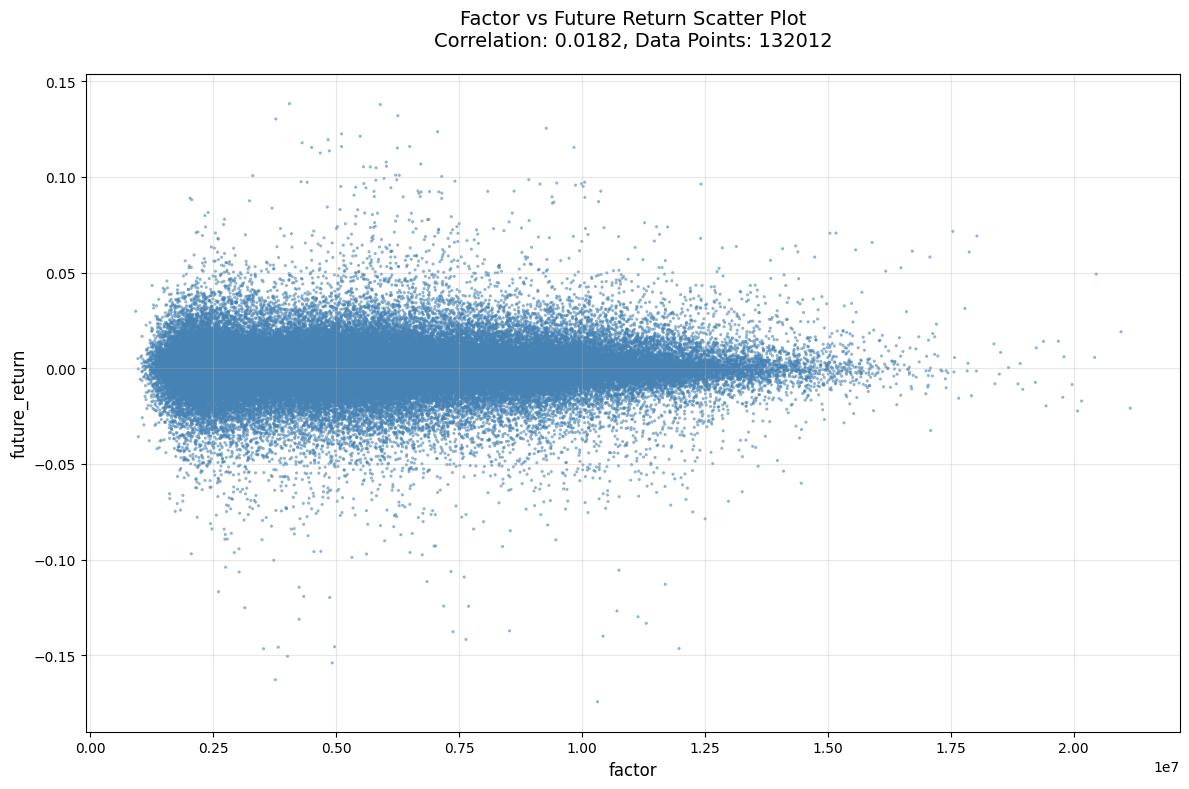

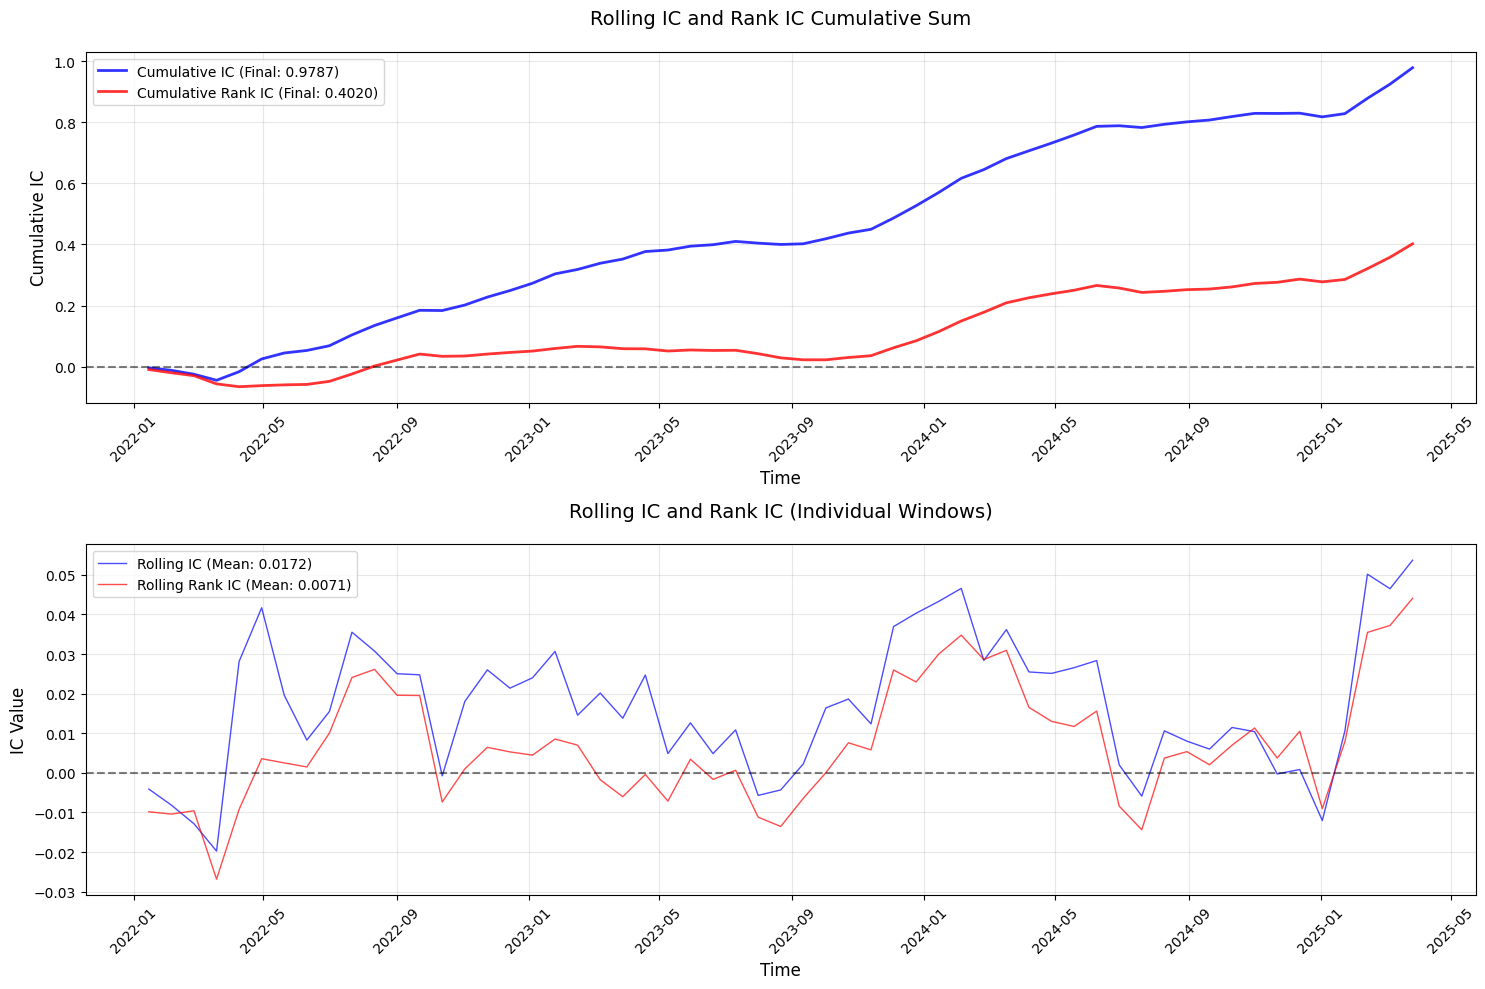

✅ 已显示 4 个图片
----------------------------------------


In [17]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=True)

In [18]:
from tabulate import tabulate

def display_factor_evaluation(result):
    # 1. 基础统计指标
    basic_metrics = [
        ["信息系数(IC)", result['correlation_analysis']['IC']],
        ["秩相关系数(Rank IC)", result['correlation_analysis']['Rank_IC']],
        ["信息比率(IR)", result['information_ratio']['IR']],
        ["分组数量", result['information_ratio']['n_groups']],
        ["数据点数", f"{result['factor_return_scatter']['data_points']:,}"],
        ["异常值(>3σ)", f"{result['factor_distribution']['outlier_analysis']['>3std']*100:.2f}%"],
        ["异常值(>5σ)", f"{result['factor_distribution']['outlier_analysis']['>5std']*100:.2f}%"]
    ]
    
    # 2. 分组分析
    group_stats = result['group_analysis']['group_stats']
    group_table = []
    for idx, row in group_stats.iterrows():
        group_table.append([
            idx,
            f"{row['val_min']:.4f}",
            f"{row['val_max']:.4f}",
            f"{row['val_mean']:.4f}",
            f"{row['return_mean']:.6f}",
            f"{row['return_std']:.4f}",
            row['count']
        ])
    
    # 3. 因子分布描述
    dist_stats = result['factor_distribution']['descriptive_stats']
    distribution_metrics = [
        ["均值", f"{dist_stats['mean']:.4f}"],
        ["标准差", f"{dist_stats['std']:.4f}"],
        ["最小值", f"{dist_stats['min']:.4f}"],
        ["1%分位数", f"{dist_stats['1%']:.4f}"],
        ["5%分位数", f"{dist_stats['5%']:.4f}"],
        ["25%分位数", f"{dist_stats['25%']:.4f}"],
        ["中位数", f"{dist_stats['50%']:.4f}"],
        ["75%分位数", f"{dist_stats['75%']:.4f}"],
        ["95%分位数", f"{dist_stats['95%']:.4f}"],
        ["99%分位数", f"{dist_stats['99%']:.4f}"],
        ["最大值", f"{dist_stats['max']:.4f}"]
    ]
    
    # 4. 分组相关性
    group_correlations = []
    for i, corr in enumerate(result['information_ratio']['group_correlations']):
        group_correlations.append([f"组 {i+1}", f"{corr:.6f}"])
    
    # 5. 滚动IC分析 - 完整展示
    rolling_ic = result['rolling_ic_analysis']['rolling_ic']
    rolling_rank_ic = result['rolling_ic_analysis']['rolling_rank_ic']
    window_centers = result['rolling_ic_analysis']['window_centers']
    cumsum_ic = result['rolling_ic_analysis']['cumsum_ic']
    cumsum_rank_ic = result['rolling_ic_analysis']['cumsum_rank_ic']
    
    # 创建滚动IC数据表格
    rolling_table = []
    for i in range(len(rolling_ic)):
        rolling_table.append([
            window_centers[i].strftime('%Y-%m-%d %H:%M:%S'),
            f"{rolling_ic[i]:.6f}",
            f"{rolling_rank_ic[i]:.6f}",
            f"{cumsum_ic[i]:.6f}",
            f"{cumsum_rank_ic[i]:.6f}"
        ])
    
    # 滚动IC汇总统计
    rolling_metrics = [
        ["滚动IC均值", f"{pd.Series(rolling_ic).mean():.6f}"],
        ["滚动IC标准差", f"{pd.Series(rolling_ic).std():.6f}"],
        ["滚动Rank IC均值", f"{pd.Series(rolling_rank_ic).mean():.6f}"],
        ["滚动Rank IC标准差", f"{pd.Series(rolling_rank_ic).std():.6f}"],
        ["累积IC终值", f"{cumsum_ic[-1]:.6f}"],
        ["累积Rank IC终值", f"{cumsum_rank_ic[-1]:.6f}"],
        ["初始窗口大小", result['rolling_ic_analysis']['initial_window']],
        ["滚动步长", result['rolling_ic_analysis']['rolling_step']]
    ]
    
    # 6. 时间窗口统计
    window_stats = []
    window_data = result['factor_distribution']['window_stats'][10]
    
    # 正确处理时间窗口统计数据
    if isinstance(window_data['stats'], pd.DataFrame):
        # 如果是DataFrame结构
        for idx, row in window_data['stats'].iterrows():
            window_stats.append([
                idx,
                f"{row['mean']:.4f}",
                f"{row['std']:.4f}",
                f"{row['skew']:.4f}",
                f"{row['lambda']:.4f}",
                row['count']
            ])
    else:
        # 如果是字典结构
        for time_range, stats in window_data['stats'].items():
            window_stats.append([
                time_range,
                f"{stats['mean']:.4f}",
                f"{stats['std']:.4f}",
                f"{stats['skew']:.4f}",
                f"{stats['lambda']:.4f}",
                stats['count']
            ])
    
    # # 7. 平稳性测试结果
    # stationarity = result['stationarity_test']
    # stationarity_metrics = [
    #     ["ADF统计量", stationarity['adf_statistic']],
    #     ["P值", stationarity['p_value']],
    #     ["1%临界值", stationarity['critical_values']['1%']],
    #     ["5%临界值", stationarity['critical_values']['5%']],
    #     ["10%临界值", stationarity['critical_values']['10%']],
    #     ["是否平稳", stationarity['is_stationary']],
    #     #["显著性水平", stationarity['alpha']]
    # ]
    
    # 打印所有结果
    print("="*80)
    print("因子评估核心指标".center(80))
    print("="*80)
    print(tabulate(basic_metrics, headers=["指标", "值"], tablefmt="grid", floatfmt=".6f"))
    
    # print("\n" + "="*80)
    # print("平稳性测试结果".center(80))
    # print("="*80)
    # print(tabulate(stationarity_metrics, headers=["指标", "值"], tablefmt="grid", floatfmt=".6f"))
    
    print("\n" + "="*80)
    print("分组分析结果".center(80))
    print("="*80)
    print(tabulate(group_table, headers=["分组", "最小值", "最大值", "平均值", "收益均值", "收益标准差", "样本数"], tablefmt="grid"))
    
    print("\n" + "="*80)
    print("因子分布统计".center(80))
    print("="*80)
    print(tabulate(distribution_metrics, headers=["统计量", "值"], tablefmt="grid", floatfmt=".4f"))
    
    print("\n" + "="*80)
    print("分组相关性".center(80))
    print("="*80)
    print(tabulate(group_correlations, headers=["分组", "相关性"], tablefmt="grid", floatfmt=".6f"))
    
    print("\n" + "="*80)
    print("滚动IC分析汇总".center(80))
    print("="*80)
    print(tabulate(rolling_metrics, headers=["指标", "值"], tablefmt="grid", floatfmt=".6f"))
    
    print("\n" + "="*80)
    print("滚动IC详细数据".center(80))
    print("="*80)
    print(tabulate(rolling_table, headers=["窗口中心", "滚动IC", "滚动Rank IC", "累积IC", "累积Rank IC"], tablefmt="grid"))
    
    print("\n" + "="*80)
    print("时间窗口统计".center(80))
    print("="*80)
    print(tabulate(window_stats, headers=["时间窗口", "均值", "标准差", "偏度", "Lambda", "样本数"], tablefmt="grid"))
    print(f"时间范围: {window_data['time_ranges']}")

# 调用展示函数
display_factor_evaluation(result)

                                    因子评估核心指标                                    
+---------------------+----------------------+
| 指标                | 值                   |
+=====================+======================+
| 信息系数(IC)        | 0.018211073511734517 |
+---------------------+----------------------+
| 秩相关系数(Rank IC) | 0.007748503247656063 |
+---------------------+----------------------+
| 信息比率(IR)        | 0.3893027360540554   |
+---------------------+----------------------+
| 分组数量            | 10                   |
+---------------------+----------------------+
| 数据点数            | 132,012              |
+---------------------+----------------------+
| 异常值(>3σ)         | 19.29%               |
+---------------------+----------------------+
| 异常值(>5σ)         | 0.63%                |
+---------------------+----------------------+

                                     分组分析结果                                     
+--------+------------------+-------------+-------------+-----------